In [1]:
import numpy as np
from scipy.interpolate import interp1d
import json
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.losses import MeanSquaredError
import tensorflow as tf

# WFDB檔資料集載入及資料前處理

In [2]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 2.8 MB/s eta 0:00:00


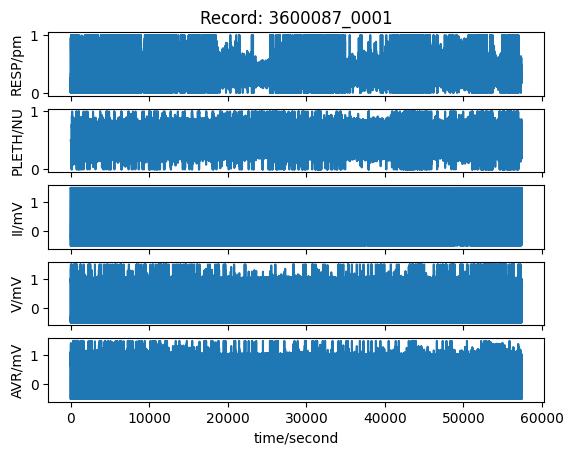

{'record_name': '3600087_0001',
 'n_sig': 5,
 'fs': 125,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 7175125,
 'base_time': datetime.time(11, 29, 35, 88000),
 'base_date': None,
 'comments': [],
 'sig_name': ['RESP', 'PLETH', 'II', 'V', 'AVR'],
 'p_signal': array([[        nan,         nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan,         nan],
        ...,
        [ 0.24828935,  0.6568915 , -0.08398438,  0.75390625,  0.80588235],
        [ 0.24535679,  0.64809384, -0.07421875,  0.75390625,  0.8       ],
        [ 0.24242424,  0.63734115, -0.06445312,  0.74414062,  0.79607843]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['3600087_0001.dat',
  '3600087_0001.dat',
  '3600087_0001.dat',
  '3600087_0001.dat',
  '3600087_0001.dat'],
 'fmt': ['16', '16', '16', '16', '16'],
 'samps_per_frame': [1, 1, 1, 1, 1],
 '

In [3]:
import wfdb

# 讀取檔案
record = wfdb.rdrecord('/content/drive/MyDrive/Colab Notebooks/PPG/異常 WFDB MIMIC/3600087_0001')
wfdb.plot_wfdb(record=record)
display(record.__dict__)


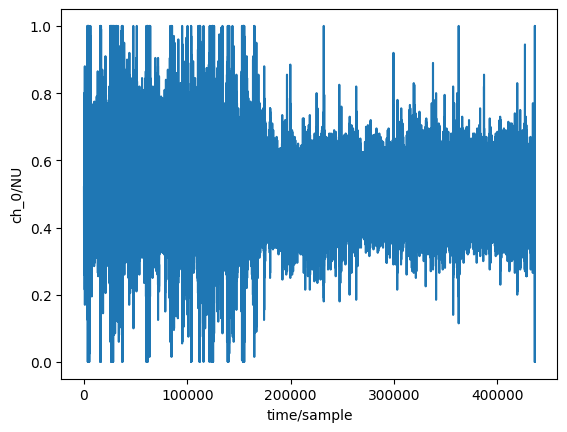

array([[0.52002931],
       [0.44992672],
       [0.42989741],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

{'fs': 125,
 'sig_len': 436250,
 'n_sig': 1,
 'base_date': None,
 'base_time': datetime.time(2, 8, 26, 388000),
 'units': ['mV'],
 'sig_name': ['III'],
 'comments': []}

In [4]:
# 只擷取PPG訊號
signals, fields = wfdb.rdsamp('/content/drive/MyDrive/Colab Notebooks/PPG/異常 WFDB MIMIC/3200013_0003', channels=[1])
wfdb.plot_items(signal=signals, fs=fields['fs'])
display(signals, fields)


In [ ]:
signals

array([[0.52002931],
       [0.44992672],
       [0.42989741],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

In [5]:
# 異常值處理
# 移除包含 nan 的行
signals1 = signals[~np.isnan(signals).any(axis=1)]

# 如果您想要的结果是一维数组
signals = signals1.flatten()

print(signals1)
print(signals)

[[0.52002931]
 [0.44992672]
 [0.42989741]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]
[0.52002931 0.44992672 0.42989741 ... 0.         0.         0.        ]


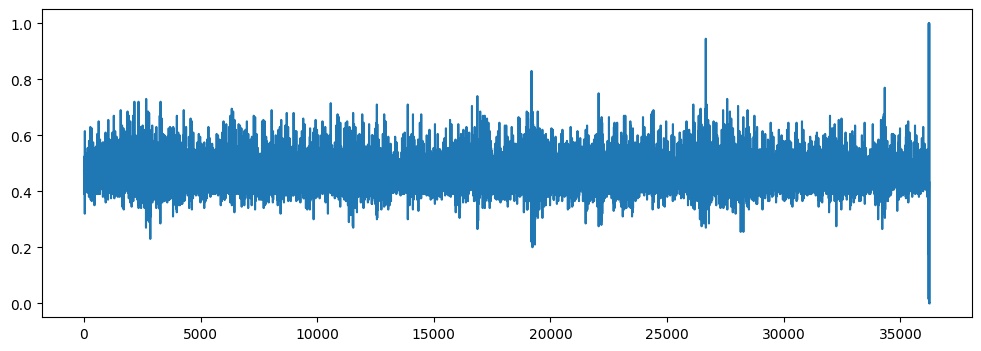

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(signals[400000:], label='Interpolated Signal')
plt.show()

# AF Data load


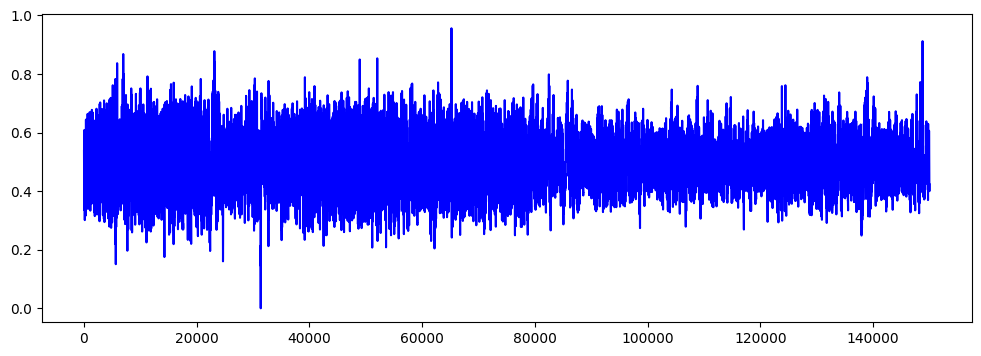

In [ ]:
signals = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PPG/mimic_perform_af_csv/mimic_perform_af_001_data.csv')
signals = signals['PPG']

# 繪圖
plt.figure(figsize=(12, 4))
plt.plot(signals, color='blue')
plt.show()

In [ ]:
ppg_signal = signals
ppg_signal

0         0.537634
1         0.534702
2         0.531769
3         0.528837
4         0.524927
            ...   
149996    0.401760
149997    0.404692
149998    0.409580
149999    0.416422
150000    0.423265
Name: PPG, Length: 150001, dtype: float64

# 重採樣(resampling)

## 上採樣(時間不變)

新的採樣率: 1000


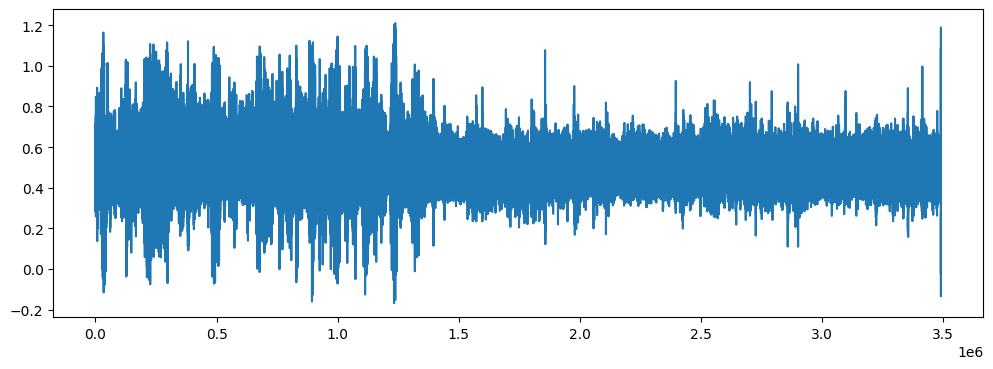

In [6]:
import numpy as np
from scipy import signal


# 定義原始採樣率和目標採樣率
fs_original = 125  # 原始採樣率 (Hz)
fs_target = 1000   # 目標採樣率 (Hz)

# 計算上採樣的比例
upsample_ratio = fs_target / fs_original

# 使用scipy的resample函數進行上採樣
signals = signal.resample(signals, int(len(signals) * upsample_ratio))

# 如果需要，可以使用插值方法進一步平滑訊號，例如使用spline插值
# upsampled_ppg_signal_smooth = signal.spline_filter(upsampled_ppg_signal, order=3)

# 打印新的採樣率
print("新的採樣率:", fs_target)
plt.figure(figsize=(12, 4))
plt.plot(signals, label='Interpolated Signal')
plt.show()

In [10]:
len(signals) // 1000

3490

# 濾波

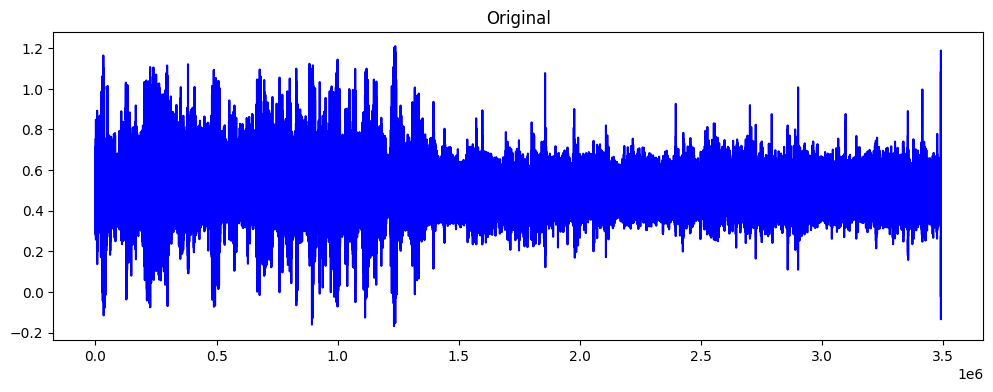

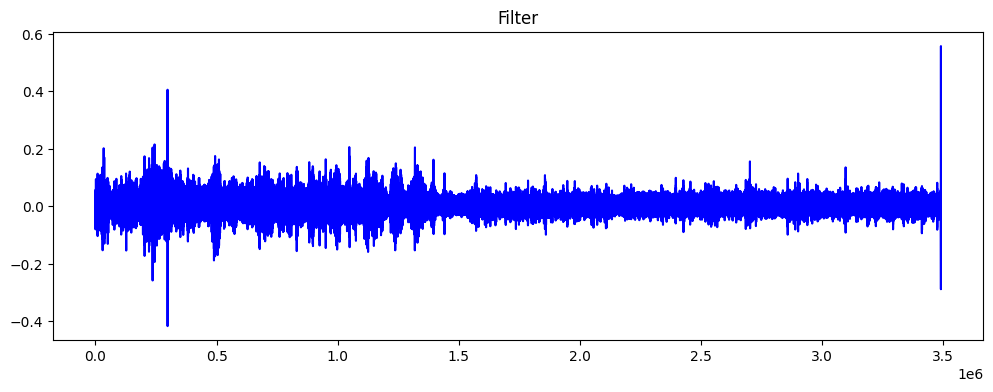

In [7]:
# 濾波
# 使用巴特沃斯濾波器(Butterworth Filter)

fs = 1000 # 樣本率(Hz)
lowcut = 0.68 # 通帶低頻(Hz)
highcut = 8.0 # 通帶高頻(Hz)
order = 5 # 濾波器的階數


# 設計巴特沃斯帶通濾波器
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = filtfilt(b, a, data)
    return y

# 開始濾波
ppg_signal = butter_bandpass_filter(signals, lowcut, highcut, fs, order=3)


# 繪圖
plt.figure(figsize=(12, 4))
plt.plot(signals, color='blue')
plt.title('Original')
plt.show()


plt.figure(figsize=(12, 4))
plt.plot(ppg_signal, color='blue')
plt.title('Filter')
plt.show()

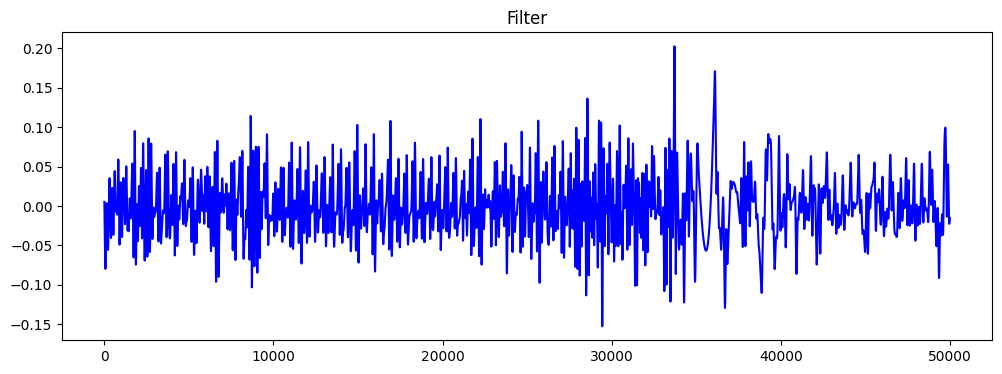

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(ppg_signal[0:50000], color='blue')
plt.title('Filter')
plt.show()

# 資料集分割

In [8]:
# 資料集分割
fs = 1000  # 採樣率(Hz)
segment_length_seconds = 5  # 預切割秒數
segment_length_points = fs * segment_length_seconds  # 每個段落應包含的數據點數量

ppg_data_noraml = ppg_signal.tolist()

# 分割PPG訊號數據
segments_ppg = [ppg_data_noraml [i: i + segment_length_points] for i in range(0, len(ppg_data_noraml), segment_length_points)]

print(f'採樣率為{fs}，預分割秒數為{segment_length_seconds}，一段為{segment_length_points}數據點')
print(f'切割{len(segments_ppg)}段')
print(f'最後一段為{len(segments_ppg[-1])}個數據點')

if segments_ppg[-1] != segment_length_points:
    segments_ppg.pop()
    print(f'最後一段不足{segment_length_points}，移除最後一段，剩餘{len(segments_ppg)}段')
    print(f'最後一段數據點為{len(segments_ppg[-1])}')

採樣率為1000，預分割秒數為5，一段為5000數據點
切割698段
最後一段為5000個數據點
最後一段不足5000，移除最後一段，剩餘697段
最後一段數據點為5000


## MinMax

In [9]:
# MinMax
# 讓每一段資料集各自做MinMax

ppg_signal_noramalized = []
scalers = []

for i in range(len(segments_ppg)):
    semgents = np.array(segments_ppg[i])
    scaler = MinMaxScaler()
    noramalized = scaler.fit_transform(semgents.reshape(-1, 1)).flatten()
    ppg_signal_noramalized.append(noramalized)
    scalers.append(scaler)

In [10]:
# 使用 np.expand_dims 增加一個批次維度
predict_input_signal = np.expand_dims(ppg_signal_noramalized, axis=0)

# predict_input_signal = np.expand_dims(segments_ppg, axis=0)

# 訓練好的模型載入及預測


In [11]:
# 加載模型
loaded_autoencoder = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/NEWMODEL/autoencoder_model')

In [12]:


predict_value = loaded_autoencoder.predict(predict_input_signal[0])


se = (ppg_signal_noramalized[19] - predict_value[19]) ** 2
mse = np.mean(se)
rmse = np.sqrt(mse)

se1 = (ppg_signal_noramalized[5] - predict_value[5]) ** 2
mse1 = np.mean(se1)
rmse1 = np.sqrt(mse1)

se2 = (ppg_signal_noramalized[11] - predict_value[11]) ** 2
mse2 = np.mean(se2)
rmse2 = np.sqrt(mse2)

se3 = (ppg_signal_noramalized[2] - predict_value[2]) ** 2
mse3 = np.mean(se3)
rmse3 = np.sqrt(mse3)

se4 = (ppg_signal_noramalized[29] - predict_value[29]) ** 2
mse4 = np.mean(se4)
rmse4 = np.sqrt(mse4)



print('異常資料')
print('-------------------')
print('mse:', mse)
print('rmse:', rmse)
print('-------------------')
print('mse:', mse1)
print('rmse:', rmse1)
print('-------------------')
print('mse:', mse2)
print('rmse:', rmse2)
print('-------------------')
print('mse:', mse3)
print('rmse:', rmse3)
print('-------------------')
print('mse:', mse4)
print('rmse:', rmse4)


22/22 [==============================] - 1s 49ms/step
異常資料
-------------------
mse: 0.014066203809039309
rmse: 0.11860102785827493
-------------------
mse: 0.016681533715009807
rmse: 0.1291570118693128
-------------------
mse: 0.036040440138390015
rmse: 0.18984319882047399
-------------------
mse: 0.017997185495797204
rmse: 0.13415358920206796
-------------------
mse: 0.01627848388791438
rmse: 0.12758716192436598


In [ ]:
a = 20
result = loaded_autoencoder.evaluate(ppg_signal_noramalized[a].reshape(1, -1), ppg_signal_noramalized[a].reshape(1, -1))

np.sqrt(result)

1/1 [==============================] - 0s 158ms/step - loss: 0.0075


0.08635735901421883

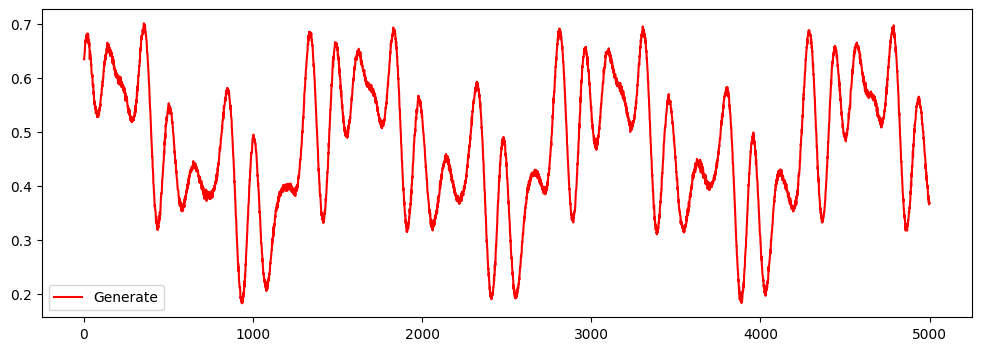

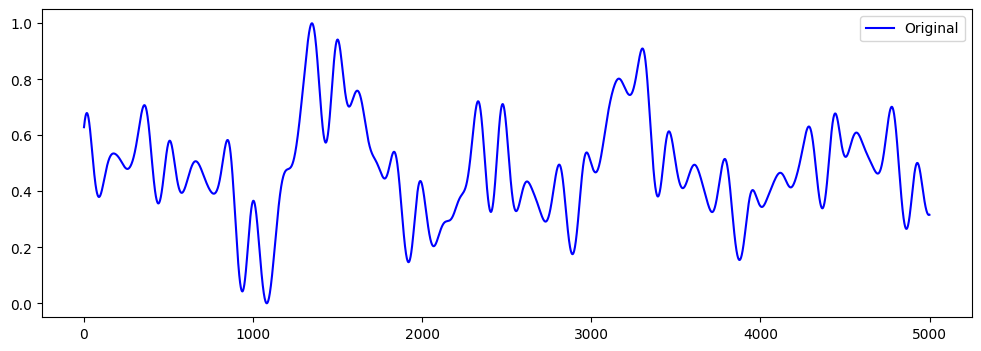

In [ ]:
x = 20

# 異常
plt.figure(figsize=(12, 4))
plt.plot(predict_value[x], color='r', label='Generate')
plt.legend()
plt.figure(figsize=(12, 4))
plt.plot(ppg_signal_noramalized[x], color='b', label='Original')
plt.legend()
plt.show()

(697, 697)

In [31]:

maes = []
rmse_list = []
normal = 0
abnormal = 0
for i in range(len(ppg_signal_noramalized)):
    result = loaded_autoencoder.evaluate(ppg_signal_noramalized[i].reshape(1, -1), ppg_signal_noramalized[i].reshape(1, -1))
    mae = np.mean(np.abs(ppg_signal_noramalized[i] - predict_value[i]))
    mape = np.mean(np.abs((ppg_signal_noramalized[i] - predict_value[i]) / ppg_signal_noramalized[i])) * 100
    ssr = np.sum((predict_value[i] - ppg_signal_noramalized[i]) ** 2)
    sst = np.sum((ppg_signal_noramalized[i] - np.mean(ppg_signal_noramalized[i])) ** 2)
    r_squared = 1 - (ssr / sst)
    rmse1 = np.sqrt(result)
    maes.append(mae)
    if r_squared < 0.99:
        abnormal += 1
    else:
        normal += 1
        plt.figure(figsize=(12, 4))
        plt.title(i)
        plt.plot(predict_value[i], color='r', label='Generate')
        # plt.figure(figsize=(12, 4))
        plt.plot(ppg_signal_noramalized[i], color='b', label='Original')
        plt.legend()
        plt.show()
        print('MSE: ', result)
        print('RMSE: ', rmse1)
        print('MAE: ', mae)
        print('MAPE: ', mape)
        print('R squared: ',r_squared)
print('normal: ', normal)
print('abnormal: ', abnormal)

1/1 [==============================] - 0s 29ms/step - loss: 0.0180


<ipython-input-31-951062f896be>:8: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((ppg_signal_noramalized[i] - predict_value[i]) / ppg_signal_noramalized[i])) * 100


1/1 [==============================] - 0s 30ms/step - loss: 0.0263
normal:  0
abnormal:  697


In [33]:
maes

[0.08843788004891624,
 0.10157464169393615,
 0.10092505693589235,
 0.0788677346296774,
 0.08584710826344186,
 0.10240002791138768,
 0.09673469579184686,
 0.12394057685178402,
 0.12742277875858427,
 0.109628494053357,
 0.11256002091005346,
 0.15489168763410743,
 0.11261656119452178,
 0.07128156148426712,
 0.08264106113162341,
 0.07923611376497941,
 0.09593737319161305,
 0.04751730952583003,
 0.0690028906430259,
 0.09421547322751621,
 0.06873944322789723,
 0.09664457623189905,
 0.0933868001040167,
 0.13629777860363043,
 0.1059863096634449,
 0.10717855254762969,
 0.13487922123545398,
 0.13101387173070222,
 0.10497493564410061,
 0.09707310429735237,
 0.13260397395691984,
 0.1270873020277582,
 0.11444525916417234,
 0.08679198507131689,
 0.07678214613238986,
 0.07238985157514444,
 0.06505566319914625,
 0.07077573980633815,
 0.08270816826648154,
 0.07027713458781293,
 0.08057385704018093,
 0.11078197187819565,
 0.13277873023640774,
 0.09006865614398193,
 0.1173160026138386,
 0.110831289559948

In [ ]:
normal:  31
abnormal:  666

In [28]:

rmse_list = []
normal = 0
abnormal = 0
for i in range(len(ppg_signal_noramalized)):
    # 反MinMax
    predict = predict_value[i]
    normalized = ppg_signal_noramalized[i]
    scaler = scalers[i]
    predict_inverse = scaler.inverse_transform(predict.reshape(-1, 1)).flatten()
    normalized_inverse = scaler.inverse_transform(normalized.reshape(-1, 1)).flatten()

    result = loaded_autoencoder.evaluate(ppg_signal_noramalized[i].reshape(1, -1), ppg_signal_noramalized[i].reshape(1, -1))
    mae = np.mean(np.abs(ppg_signal_noramalized[i] - predict_value[i]))
    mape = np.mean(np.abs((normalized_inverse[i] - predict_inverse[i]) / normalized_inverse[i])) * 100
    ssr = np.sum((predict_value[i] - ppg_signal_noramalized[i]) ** 2)
    sst = np.sum((ppg_signal_noramalized[i] - np.mean(ppg_signal_noramalized[i])) ** 2)
    r_squared = 1 - (ssr / sst)
    rmse1 = np.sqrt(result)
    if mape > 20:
        abnormal += 1
    else:
        normal += 1
        plt.figure(figsize=(12, 4))
        plt.title(i)
        plt.plot(predict_value[i], color='r', label='Generate')
        # plt.figure(figsize=(12, 4))
        plt.plot(ppg_signal_noramalized[i], color='b', label='Original')
        plt.legend()
        plt.show()
        print('MSE: ', result)
        print('RMSE: ', rmse1)
        print('MAE: ', mae)
        print('MAPE: ', mape)
        print('R squared: ',r_squared)
print('normal: ', normal)
print('abnormal: ', abnormal)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
min(rmse_list)

0.09250442754452734

## AF


In [ ]:
predict_value = loaded_autoencoder.predict(predict_input_signal[0])


se = (interpolated_ppg_signal[10] - predict_value[10]) ** 2
mse = np.mean(se)
rmse = np.sqrt(mse)

se1 = (interpolated_ppg_signal[40] - predict_value[40]) ** 2
mse1 = np.mean(se1)
rmse1 = np.sqrt(mse1)

se2 = (interpolated_ppg_signal[100] - predict_value[100]) ** 2
mse2 = np.mean(se2)
rmse2 = np.sqrt(mse2)

se3 = (interpolated_ppg_signal[150] - predict_value[150]) ** 2
mse3 = np.mean(se3)
rmse3 = np.sqrt(mse3)

se4 = (interpolated_ppg_signal[220] - predict_value[220]) ** 2
mse4 = np.mean(se4)
rmse4 = np.sqrt(mse4)


print('異常資料')
print('-------------------')
print('mse:', mse)
print('rmse:', rmse)
print('-------------------')
print('mse:', mse1)
print('rmse:', rmse1)
print('-------------------')
print('mse:', mse2)
print('rmse:', rmse2)
print('-------------------')
print('mse:', mse3)
print('rmse:', rmse3)
print('-------------------')
print('mse:', mse4)
print('rmse:', rmse4)

8/8 [==============================] - 1s 104ms/step
異常資料
-------------------
mse: 0.00895863804114505
rmse: 0.09465008209793085
-------------------
mse: 0.009055984988316439
rmse: 0.09516293915341434
-------------------
mse: 0.010793147255774531
rmse: 0.10389007294142463
-------------------
mse: 0.006288349477255953
rmse: 0.07929911397522643
-------------------
mse: 0.010923536640308783
rmse: 0.1045157243686747


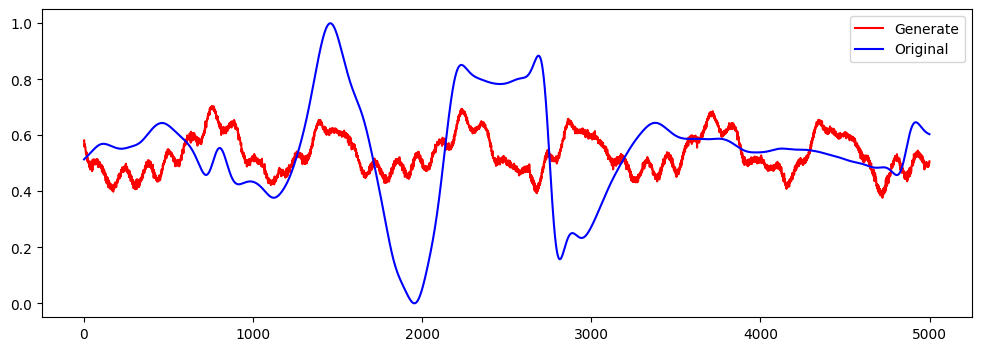

In [ ]:
# 異常
plt.figure(figsize=(12, 4))
plt.plot(predict_value[10], color='r', label='Generate')
# plt.figure(figsize=(12, 4))
plt.plot(ppg_signal_noramalized[10], color='b', label='Original')
plt.legend()
plt.show()